![Py4Eng](img/logo.png)

# Bayesian inference
## Yoav Ram

In this session we will understand:
- what the prior and posterior distributions are
- how to compute the posterior from the prior and likelihood
- how to estimate the posterior using MCMC

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import seaborn as sns
sns.set_context('talk')

red, blue, green = sns.color_palette('Set1', 3)

Statistical inference uses scientific models to explain observable phenomena.

Statistical inference applies mathematical and computational methods to draw conclusions on _Models_ from the _Theoretical World_ using  _Data_ from the _Real World_.

![Big picture of statistical inference](img/bigpic.png)

**Fig 1. from [Kass 2011](http://www.stat.cmu.edu/~kass/papers/bigpic.pdf).**


The two major approaches to statistical inference (and statistics as a whole) are the **frequentist** and **Bayesian** approaches, but we can use both, in the spirit of [_Statistical pragmatism_](http://www.stat.cmu.edu/~kass/papers/bigpic.pdf).

# Bayes' theorem
Consider the events $A$ and $B$, then Bayes' theorem states that

$$
P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}
$$

Applied to model-based inference, we define:
- $\theta$ - the model parameters
- $X$ - the data
and we have

$$
P(\theta \mid X) = \frac{P(X \mid \theta) P(\theta)}{P(X)}
$$
where
- $P(\theta)$ is called the **prior probability** that formulates our beliefs about the model before seeing any data
- $P(X \mid \theta)$ is the probability of observing $X$ given $\theta$, what we called the **likelihood** of $\theta$
- $P(\theta \mid X)$ is called the **posterior probability**, that is, how our beliefs about the model changed due to observing the data
- $P(X)$ is the probability of observing the data unconditioned on the model; we usually ignore it as it does not depend on the model

In Bayesian inference we attempt to estimate the posterior distribution over the model parameters; this constrast with classical/frequentist approaches like *maximum likelihood* in which we attempt to estimate a point estimate of the parameters - a single parameter value.

# Simple model for photon counts

This example follows a [blog post by Jake VanDerPlas](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/).

Imagine that we point our telescope to the sky, and observe the [light coming from a single star](https://en.wikipedia.org/wiki/Photon_statistics). For the time being, we'll assume that the star's true flux is constant with time, i.e. that is it has a fixed value $\mu$ (we'll also ignore effects like sky noise and other sources of systematic error). We'll assume that we perform a series of $n$ measurements with our telescope, where the $i^{\rm th}$ measurement reports the observed photon flux $X_i$.

$$
X_i \sim Poi(\mu)
$$

The question is, given this set of measurements $\{X_i\}$, what is our best estimate of the true flux $\mu$?

We start by generating some data.

In [2]:
np.random.seed(1)

# true flux: number of photons measured in 1 second
μ = 1000  
# number of measurements
n = 50 
# n measurements of the flux
X = np.random.poisson(μ, size=n)

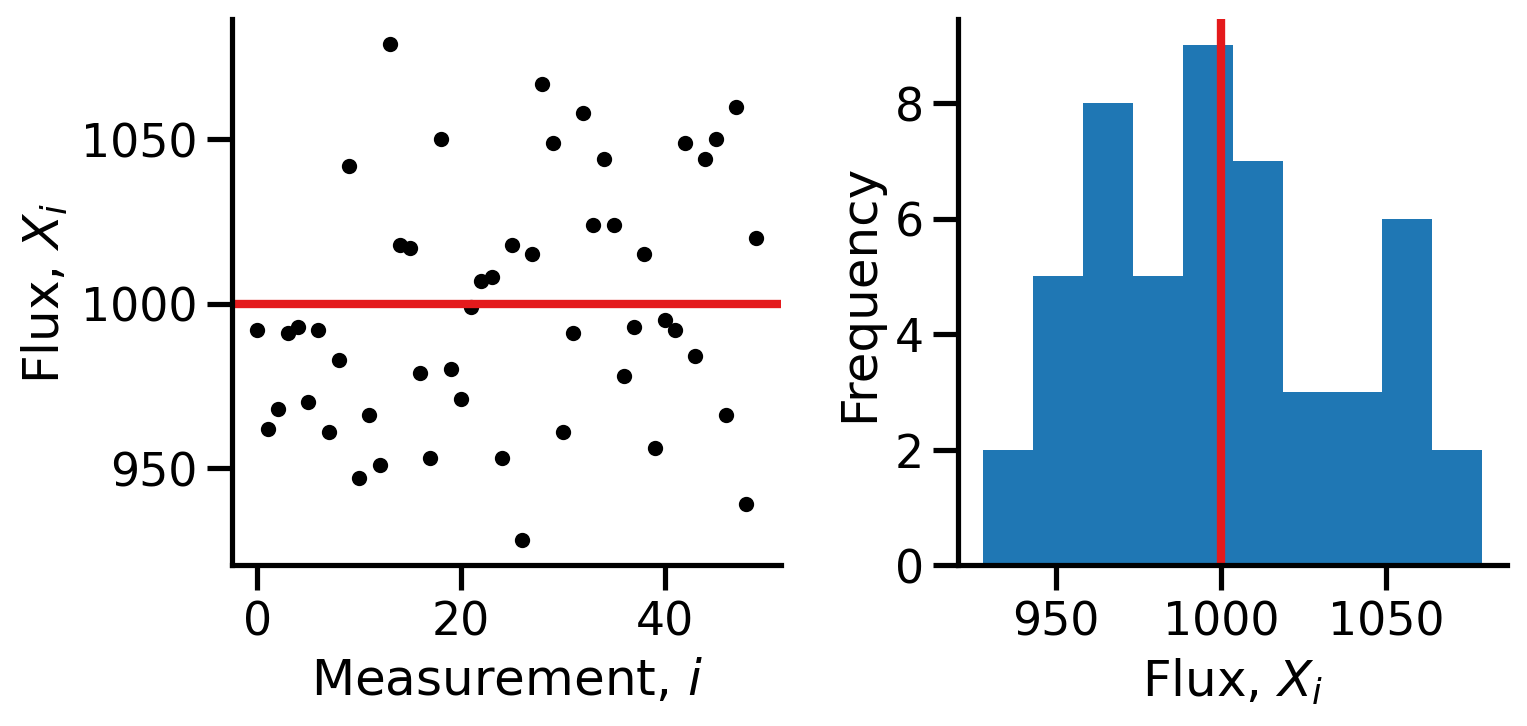

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(n), X, '.k')
ax.axhline(μ, linewidth=3, color=red)
ax.set_xlabel("Measurement, $i$")
ax.set_ylabel("Flux, $X_i$")

ax = axes[1]
ax.hist(X, bins=10)
ax.axvline(μ, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Frequency")
ax.set_xlabel("Flux, $X_i$")

fig.tight_layout()
sns.despine()

In this toy example we already know the
true flux $\mu$, but the question is this: **given our measurements, what is our best estimate of the true flux?**

## Maximum likelihood

Formally, the **likelihood $\mathcal{L}$ of the model 
$$
X_i \sim Poi(\mu)
$$
given observed data $\{(X_i)\}_i$ is the probability of seeing data given the model:**
$$
P(X \mid \mu) = 
\prod_{i=1}^n P(x_i~|~\mu)
$$

We assume (or even know) that the distribution of the measurements $\{X_i\}$ is Poisson.
Therefore, the probability to see $X_i$ given $\mu$ is
$$
P(X_i~|~\mu) = 
\frac{\mu^{X_i} e^{-\mu}}{X_i!}
$$

So the likelihood $\mathcal{L}$ is a product of exponents.
Therefore, we take the log-likelihood $\log\mathcal{L}$:

$$
\log P(X \mid \mu) = 
\sum_{i=1}^n \log{P(X_i~|~\mu)}
$$

This can be implemented in Python using SciPy:

In [4]:
def log_likelihood(μ, X):
    return scipy.stats.poisson(μ).logpmf(X).sum()

The flux value $\hat{\mu}$ that maximizes the log-likelihood $\log\mathcal{L}$ will be our **maximum likelihood estimate $\hat{\mu}$**.

We can find this analytically by solving for the root of the derivative of the normal approximation of the log-likelihood -- we would find that the maximum likelihood estimate $\hat{\mu}$ is the _arithmetic mean_.

We could also solve this as a minimization problem using `scipy.optimize.minimize`.

In [5]:
import scipy.optimize
result = scipy.optimize.minimize(lambda μ: -log_likelihood(μ, X), [0], bounds=[(X.min(), X.max())])
print('Success?', result.success)
μ_hat = result.x[0] # should be close to X.mean()
print("μ = {} \nμ_hat = {:.2f}".format(μ, μ_hat))

Success? True
μ = 1000 
μ_hat = 999.04


Let's plot the likelihood and the maximum likelihood estimate (MLE) versus the truth.

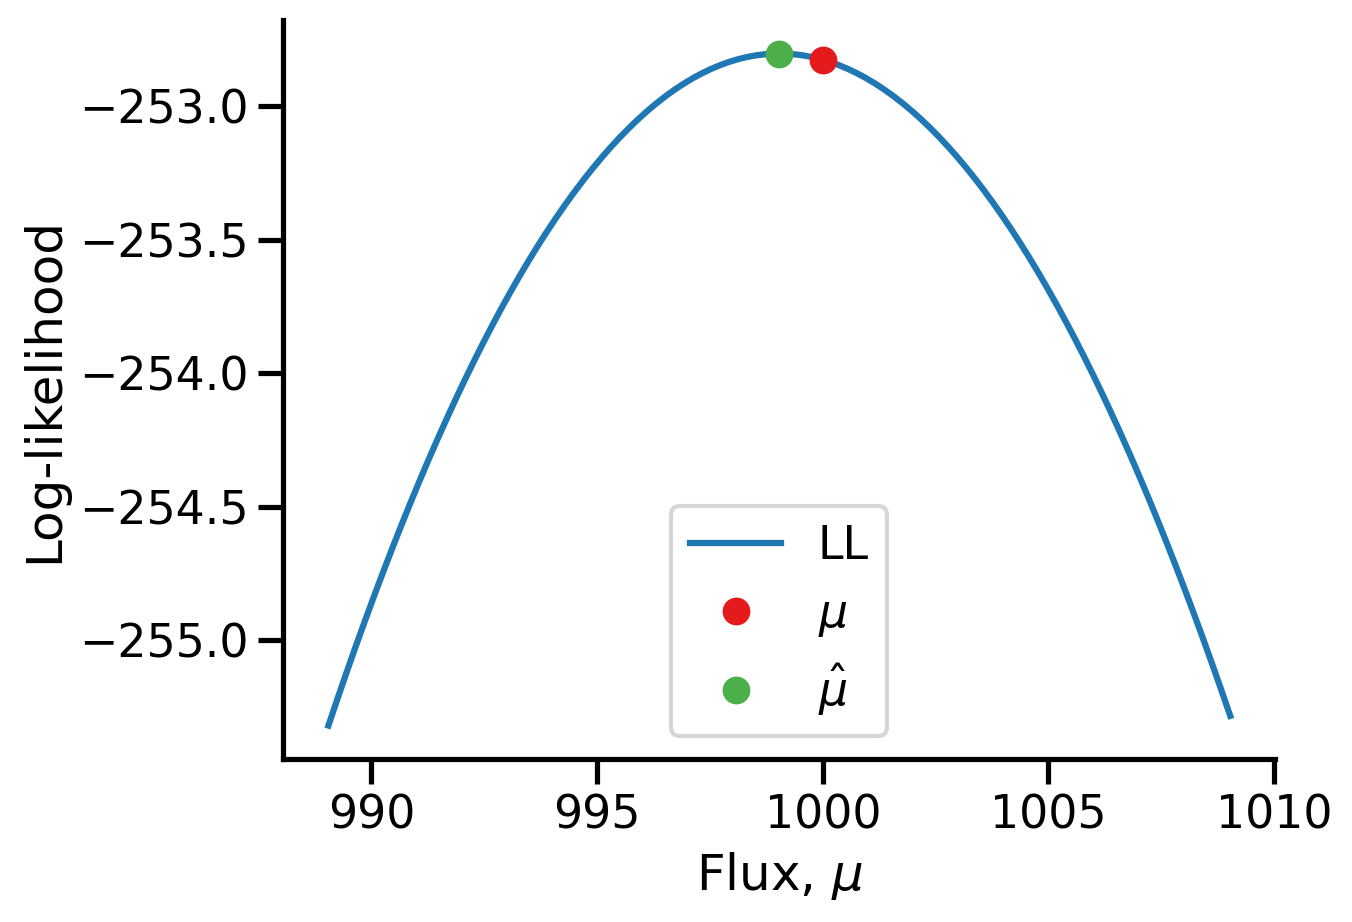

In [6]:
μ_range = np.linspace(μ_hat*0.99, μ_hat*1.01, 100)
plt.plot(μ_range, [log_likelihood(μ_, X) for μ_ in μ_range], label='LL')
plt.plot(μ, log_likelihood(μ, X), 'o', color=red, label='$μ$')
plt.plot(μ_hat, log_likelihood(μ_hat, X), 'o', color=green, label='$\hat{μ}$')

plt.xlabel("Flux, $\mu$")
plt.ylabel("Log-likelihood")
plt.legend()
sns.despine()

## Bayesian inference

In the Bayesian approach, we want to compute the  posterior distribution of the model parameter
$$
P(\mu \mid X) = \frac{P(X \mid \mu) P(\mu)}{P(X)},
$$
which reflects our knowledge or beliefe on the parameter $\mu$.

This is important: we actually want to form a belief (or opinion) on any value of the $\mu$ parameter (which is expressed by the posterior probability $P(\mu \mid X)$), rather than just choosing the value that fits best to the data (which is what maximum likelihood does)

We can't compute $P(X)$, but given a definition of the prior $P(\mu)$ and likelihood $P(X \mid \mu)$ we can compute the posterior $P(\mu \mid X)$ for any $\mu$ up to a constant -- that constant is $P(X)$.
So if we then normalize we can get the posterior.

Let's assume the prior is uniform in the positive values (although this is an improper choice, as it is not a real distribution):

$$
P(\mu = u) = \begin{cases}
1, & u > 0 \\
0, & \text{otherwise}
\end{cases}
$$


Therefore the log-prior is:

$$
logP(\mu = x) = \begin{cases}
0, & x > 0 \\
-\infty, & \text{otherwise}
\end{cases}
$$

Therefore, the log-posterior is the sum of the log-likelihood and the log-prior:
$$
logP(X \mid \mu) = \log P(X \mid \mu) + \log{P(\mu)}.
$$
where $X_i$ ($1 \le i \le n$) are the data points in $X$ and $\mu>0$.

In [7]:
def log_prior(μ):
    if μ > 0:
        return 0
    else:
        return -np.inf

def log_posterior(μ, X):
    logpr = log_prior(μ)
    if np.isinf(logpr): 
        # dont compute log-likelihood in this case
        return logpr
    else: 
        return logpr + log_likelihood(μ, X)

This is a one-dimensional problem, so we can work with a direct approach; that won't work with multi-dimensional problems, and therefore it is common to use sampling methods such as _Markov chain Monte Carlo_, or _MCMC_.

Let's do it anyway.
Since we can't compute for every positive $\mu$ lets just do it for $min(X) < \mu < max(X)$, as we can assume the posterior probability is very small for $\mu$ values that outside the range of the data.

Our point estimate will be the maximum of the posterior (i.e. _MAP_), rather than that of the likelihood (although there is not differene in this case because of the uniform prior).

In [8]:
μ_range = np.linspace(X.min(), X.max(), 100)
pri = np.exp([log_prior(μ_) for μ_ in μ_range])
lik = np.exp([log_likelihood(μ_, X) for μ_ in μ_range])
post = np.exp([log_posterior(μ_, X) for μ_ in μ_range])
μ_hat = μ_range[post.argmax()] # maximum a posterioi estimate
print("μ = {} \nμ_hat = {:.2f}".format(μ, μ_hat))

μ = 1000 
μ_hat = 999.69


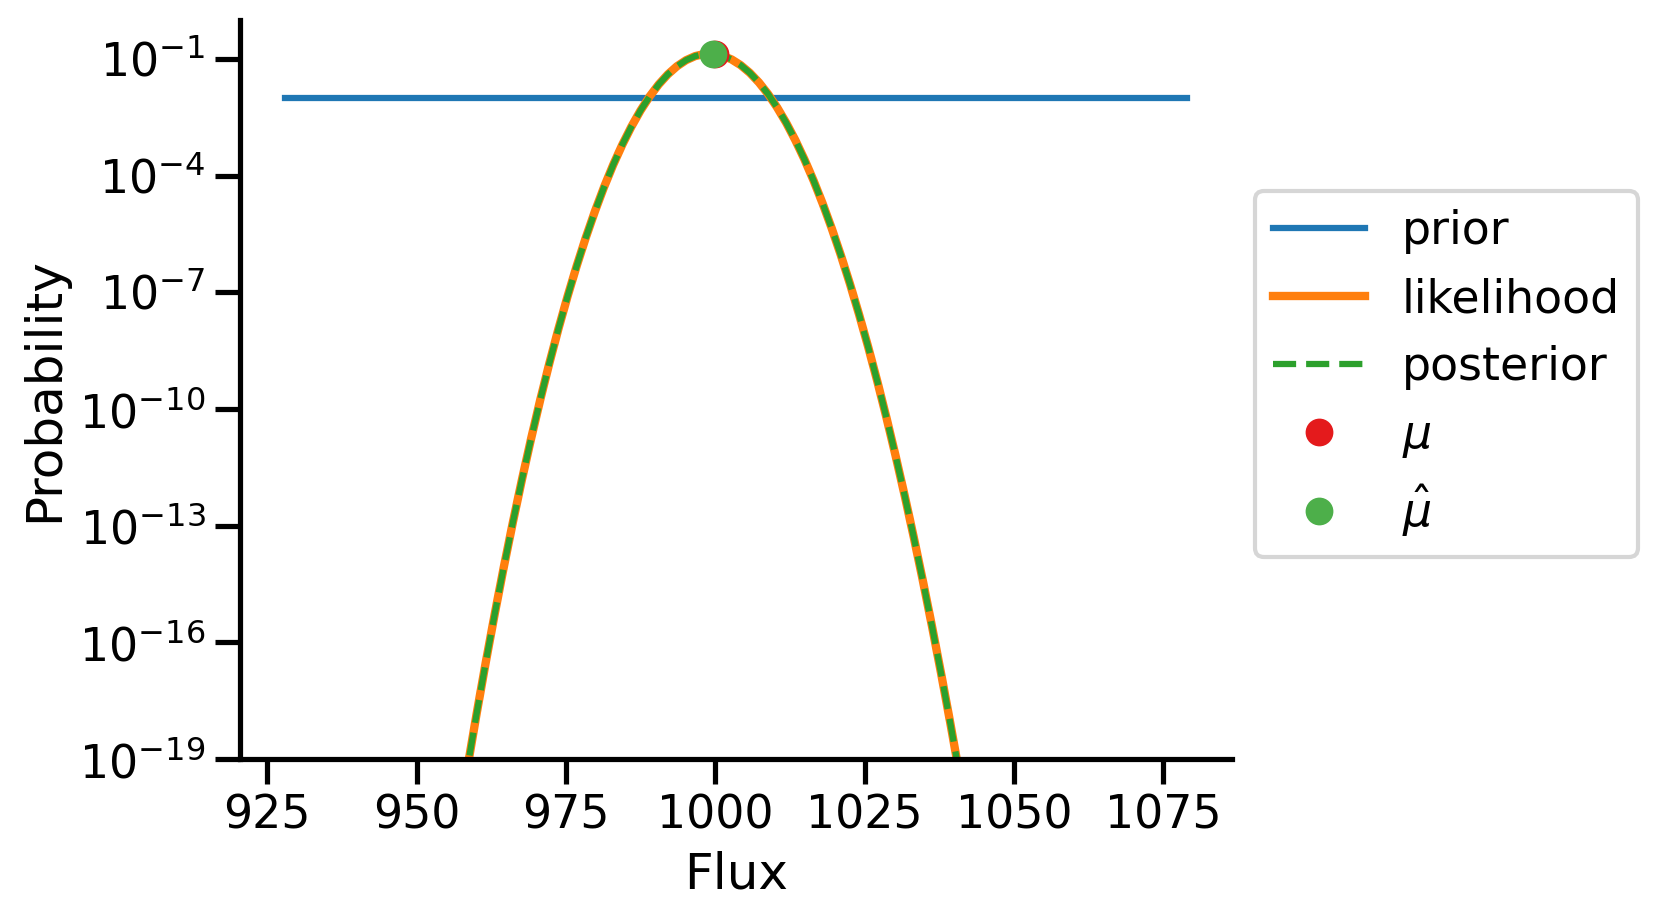

In [9]:
plt.plot(μ_range, pri/pri.sum(), label='prior')
plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')
plt.plot(μ, np.exp(log_posterior(μ, X))/post.sum(), 'o', color=red, label='$μ$')
plt.plot(μ_hat, np.exp(log_likelihood(μ_hat, X))/post.sum(), 'o', color=green, label='$\hat{μ}$')

plt.xlabel("Flux")
plt.ylabel("Probability")
plt.yscale('log')
plt.ylim(1e-19, 1)
plt.legend(bbox_to_anchor=(1, 0.8))
sns.despine()

## Exercise

Change the prior to something more informative:

$$
\mu \sim \text{Normal}(990, 10)
$$

Then plot the prior, likelihood, and posterior again.

Remember that the prior must not give positive probability to negative values, as negative $\mu$ values cannot be the parameter of a Poisson distribution.

See [solution](../solutions/bayesian.ipynb).

In [10]:
def log_prior(μ):
    # your code here

μ = 1000 
μ_hat = 997.58


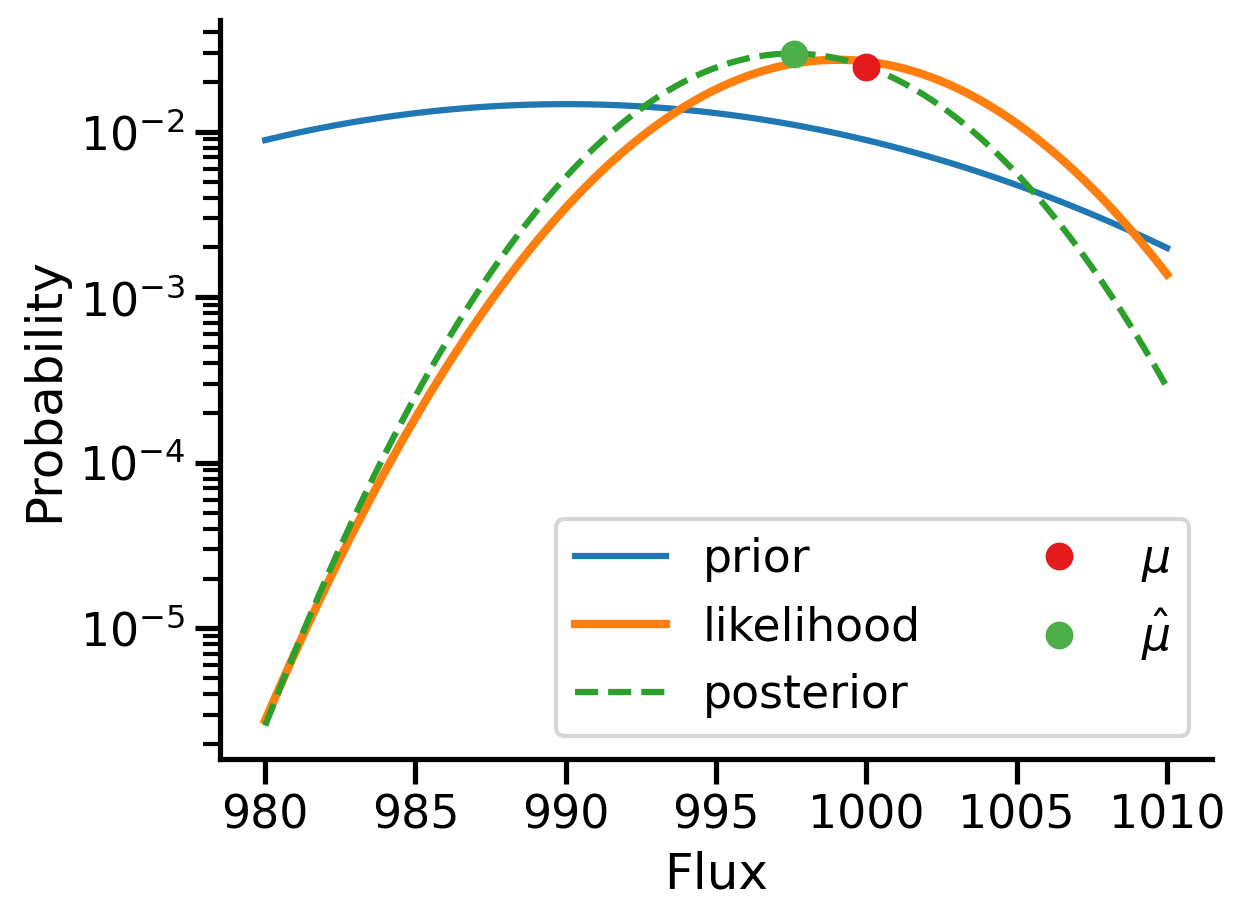

In [11]:
μ_range = np.linspace(μ*0.98, μ*1.01, 100)
pri = np.exp([log_prior(μ_) for μ_ in μ_range])
lik = np.exp([log_likelihood(μ_, X) for μ_ in μ_range])
post = np.exp([log_posterior(μ_, X) for μ_ in μ_range])
μ_hat = μ_range[post.argmax()] # maximum a posterioi estimate
print("μ = {} \nμ_hat = {:.2f}".format(μ, μ_hat))

plt.plot(μ_range, pri/pri.sum(), label='prior')
plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')
plt.plot(μ, np.exp(log_posterior(μ, X))/post.sum(), 'o', color=red, label='$μ$')
plt.plot(μ_hat, np.exp(log_posterior(μ_hat, X))/post.sum(), 'o', color=green, label='$\hat{μ}$')

plt.xlabel("Flux")
plt.ylabel("Probability")
plt.yscale("log")
plt.legend(ncol=2)
sns.despine()

# Monte Carlo: Sampling instead of computing

For anything that has more than one or two parameters we cannot do the above exhustive method as the complexity increases with the number of parameters (or the dimension of the parameter space).

A common approach is therefore to use *Monte Carlo* or sampling methods. 
With Monte Carlo, instead of directly computing the posterior distribution, we indirectly sample from the posterior distribution.

**Note**: this is an important shift in our methodology. **Instead of computing, we sample**. That is, instead of finding the function $P(\mu \mid X)$, we want to find a set of $m$ samples from the posterior $\{\mu_i\}$ such that $P(\mu_i = u) = P(\mu=u \mid X)$.

Monte Carlo methods are used in a variety of applications other then posterior sampling.

For example, consider the function $f(x) = e^{-2x}$.

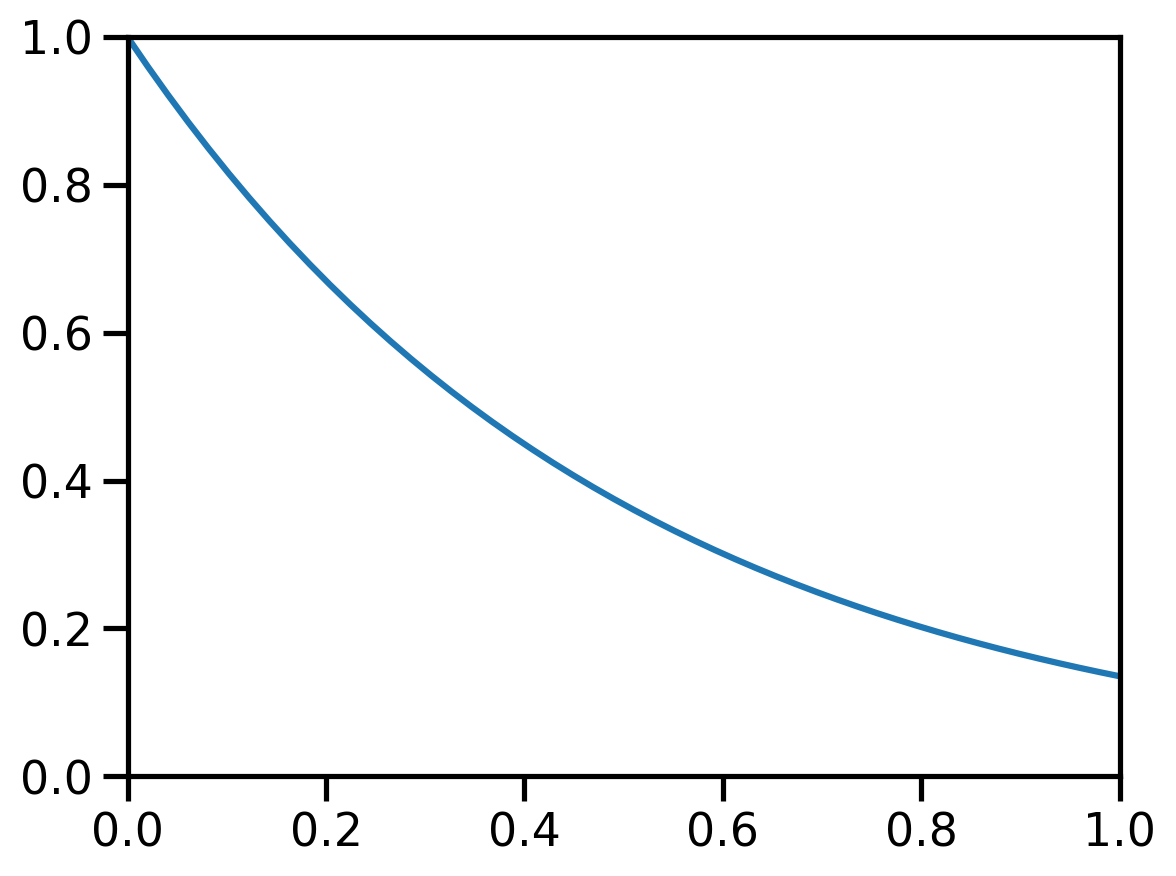

In [12]:
def f(x):
    return np.exp(-2*x)

x = np.linspace(0, 1)
plt.plot(x, f(x))
plt.xlim(0, 1)
plt.ylim(0, 1);

If we wish to compute the integral $\int_0^1{f(x)}$, we can draw random points in the unit square and compute the fraction of point below the function curve. This would approximate the integral value.

estimate:	 0.4293
real:		 0.43233235838169365


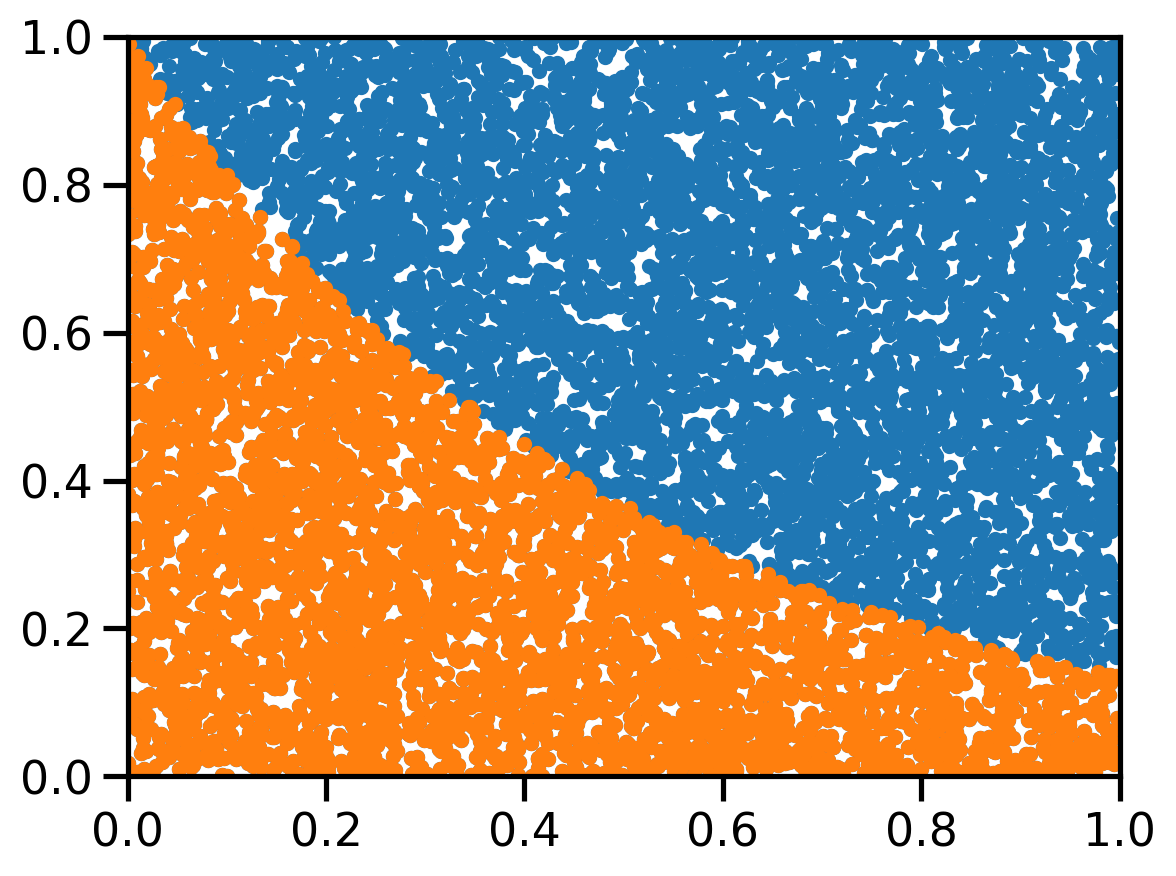

In [13]:
N = 10000
x, y = np.random.random((2, N))
accepted = y < f(x)
print('estimate:\t', accepted.mean())
print('real:\t\t', 0.5 - 1/(2 * np.exp(2)))

plt.plot(x, y, '.')
plt.plot(x[accepted], y[accepted], '.')
plt.xlim(0, 1)
plt.ylim(0, 1);

This method of sampling is called __rejection sampling__ and we can employ if for sampling from the posterior distribution (instead of the area below `f(x)`.

## Rejection sampling

Given empirical data $X$, a model parameterized by the vector $\theta$, a prior $P(\theta)$, and likelihood $P(X \mid \theta)$, the following describes the *rejection sampling algorithm*:

1. Generate candidate parameter value from the prior $\theta^* \sim P(\theta)$  
1. Compute the likelihood for the candidate parameter $P(X \mid \theta^*)$
1. Accept $\theta^*$ with probability proportional to $P(X \mid \theta^*)$.

This process effectivelty samples from the posterior, as the probability to draw $\theta^*$ proportinal to $P(X \mid \theta^*) P(\theta^*)$. 

Therefore, the collection of accepted $\theta^*$ values _approximates_ the posterior distribution $P(\theta \mid x)$.

The proportion of accepted values is called the __acceptance rate__, and it can be very low if the prior is very different from the posterior (which frequently occurs if we don't know much about the parameter values). For example, if we run the following with a "flat" (uniform) prior, we will get an acceptance rate of about 1:100,000.
With an informative prior - a Gaussian around the mean of the data - we still only have an acceptance rate of about 1:10,000.

So we have to take at least 100,000 samples, and the running time is therefore long.

In [14]:
N = 10000
# sample from prior
prior = scipy.stats.norm(990, 10)
μs = prior.rvs(N) 
# accept or reject according to likelihood/prior
log_liks = np.array([log_likelihood(μ_, X) for μ_ in μs]) # compute log-likelihood
liks = np.exp(log_liks) # exponentiate to get likelihood
liks /= liks.sum() # normalize
liks /= prior.pdf(μs) # divide by prior

randoms = np.random.random(N) # draw randoms
accepted = randoms < liks # accept or reject
accept_rate = accepted.mean()
print("Acceptance rate: ", accept_rate)

Acceptance rate:  0.0037


In [15]:
μ_hat = μs[accepted].mean()
print("μ = {} \nμ_hat = {:.2f}".format(μ, μ_hat))

μ = 1000 
μ_hat = 999.24


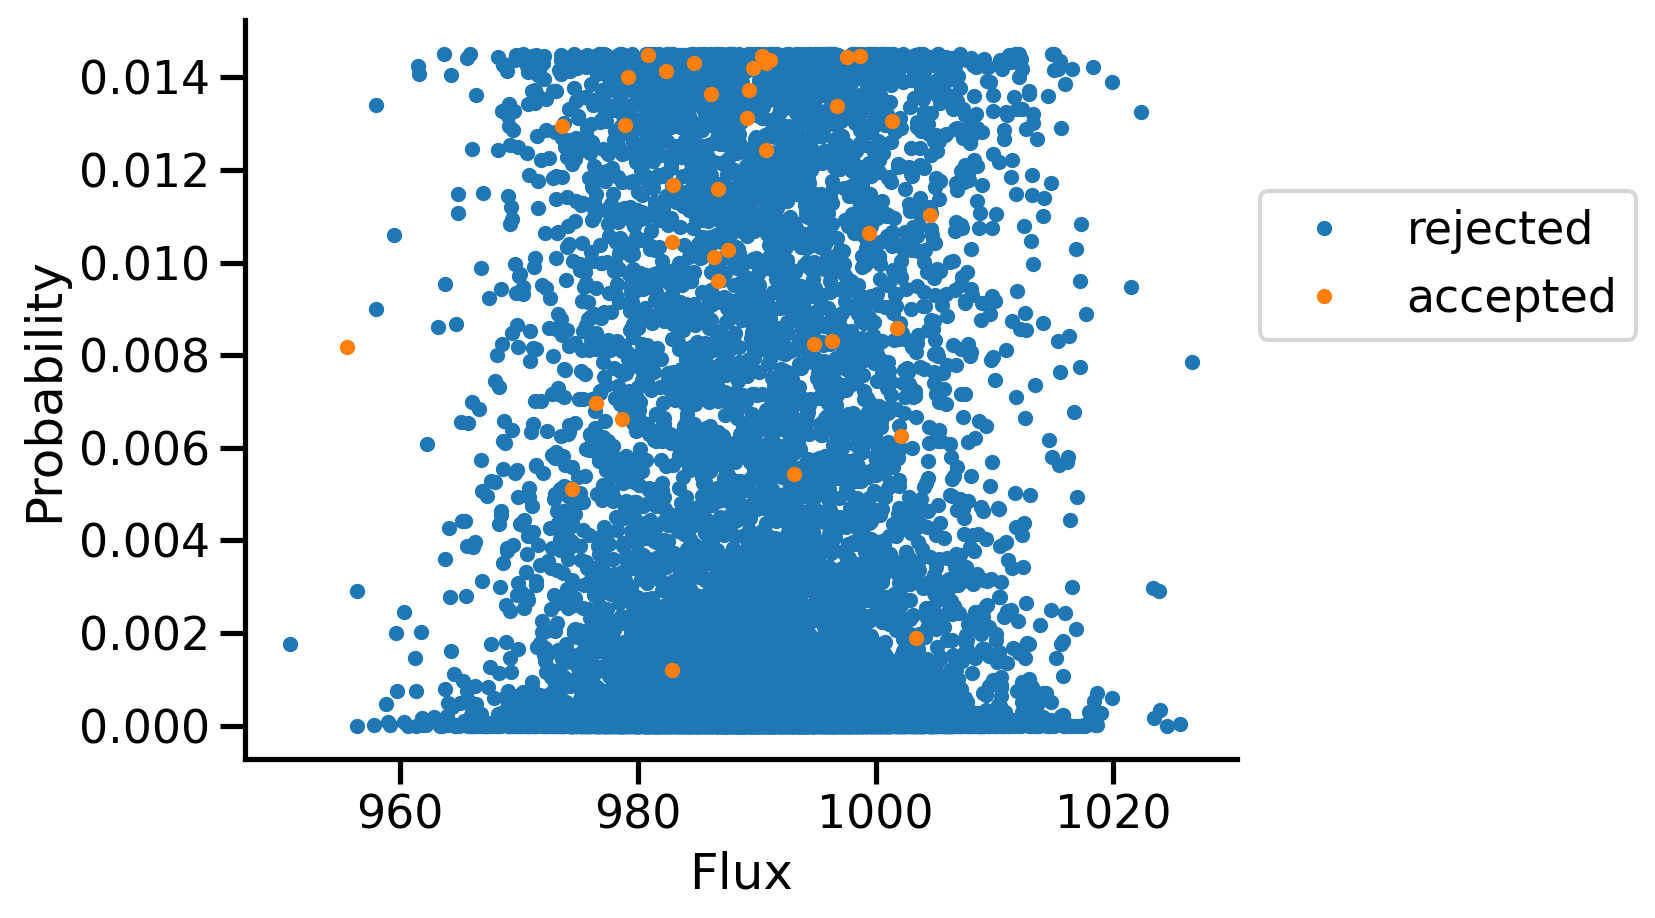

In [16]:
μs.sort()
plt.plot(μs[~accepted], liks[~accepted], '.', label='rejected')
plt.plot(μs[accepted], liks[accepted], '.', label='accepted')
plt.legend(bbox_to_anchor=(1, 0.8))
plt.xlabel('Flux')
plt.ylabel('Probability')
sns.despine()

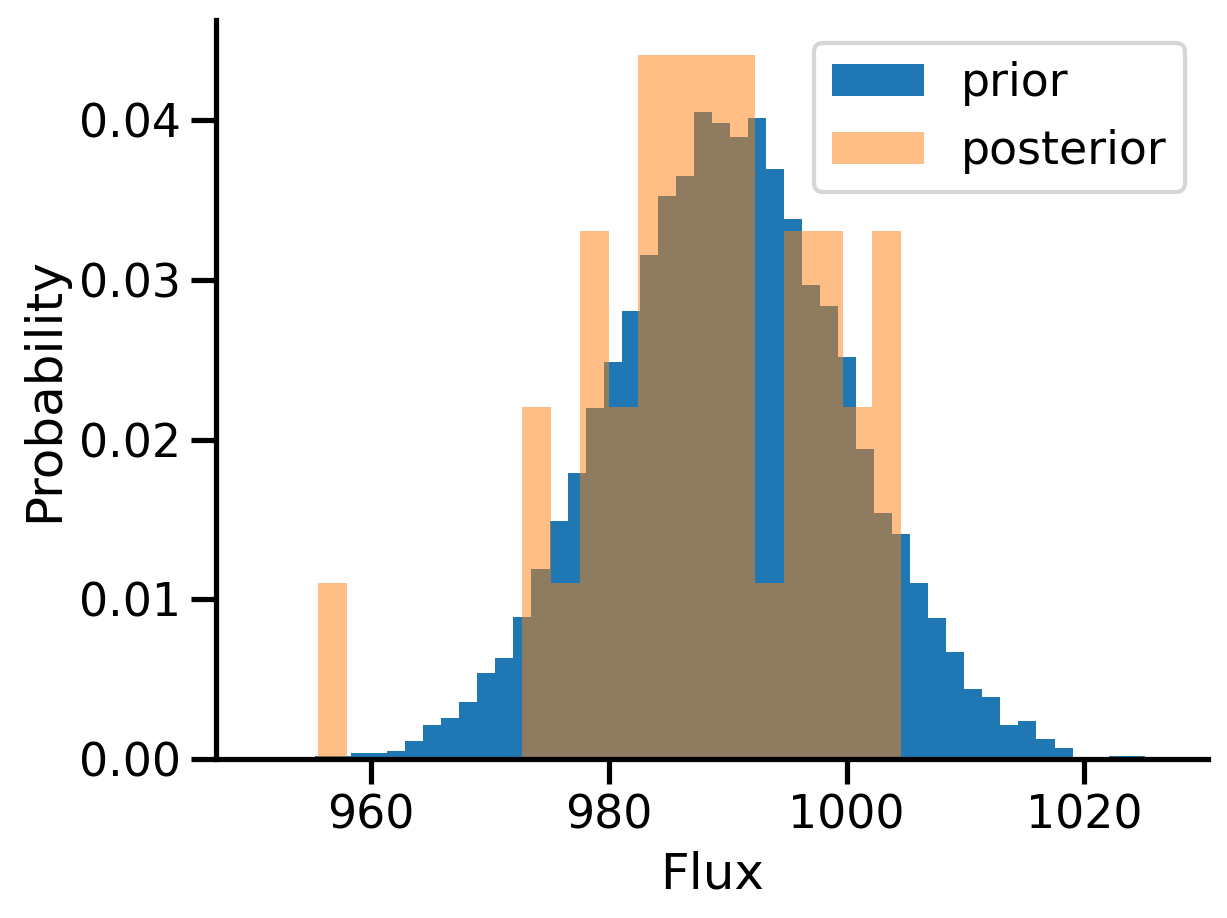

In [17]:
plt.hist(μs, bins=50, density=True, label='prior')
plt.hist(μs[accepted], bins=20, density=True, alpha=0.5, label='posterior')
plt.legend()
plt.xlabel('Flux')
plt.ylabel('Probability')
sns.despine()

The problem with the rejection method is that the acceptance rate can be very low, which requires us to draw many samples from the prior, and compute the log-likelihood many times, and this is very wasteful.

We'll deal with that in the next section.

## Markov chain Monte Carlo: MCMC

Markov chain Monte Carlo is a family of clever algorithms for sampling with the prior with a much higher acceptance rate by concentrating on the areas of high likelihood.

We create "chains" of accepted parameter samples of length $N$ using the following algorithm.

The most well-known, maybe, of these algorithms is the **Metropolis–Hastings** algorithm.

At iteration $i$, given the previous parameter value $\theta_i$, we
1. Generate a candidate parameter value $\theta^*$ from a proposal distribution $\theta^* \sim N(\theta_i, \eta)$.
1. Compute the likelihood $P(X \mid \theta^*)$.
1. Set the acceptance probability $\alpha = \frac{P(\theta^* \mid X)}{P(\theta_i \mid X)} = \frac{P(X \mid \theta^*)P(\theta^*)}{P(X \mid \theta_i)P(\theta_i)}$ to the ratio of posterior probabilities.
1. Set $\theta_{i+1} = \theta^*$ with probability $min(1,\alpha)$ (i.e. accept $\theta^*$), otherwise set $\theta_{i+1} = \theta_i$ (i.e. reject $\theta^*$ and keep $\theta_i$ again).

_Note:_
in the more general case, we can use a proposal distribution $q(\theta \mid \theta_i)$ and then we set $\alpha = \frac{P(X \mid \theta^*) q(\theta_i \mid \theta^*)}{P(X \mid \theta_i) q(\theta^* \mid \theta_i)}$. If we use the gaussian proposal distribution, then it is symmetric around the mean $q(\theta_i \mid \theta^*) = q(\theta^* \mid \theta_i)$, and $\alpha$ simplifies.

This sampling algorithm is much more efficient than the rejection sampling, as it is able to "spend more time" in areas of high likelihood.

However, this algorithm can get stuck on areas of low likelihood.

In [18]:
η = 0.5 # proposal width, exploration rate
N = 10000 # chain length
burnin = N // 2 # the first 50% of samples are removed, used only to get closer to the real value
accept = 0

μ_samples = np.empty(N)
μ_samples[0] = np.random.uniform(X.min(), X.max()) # initial guess 
logposterior = log_likelihood(μ_samples[0], X) + log_prior(μ_samples[0])

# prepare random numbers for efficient sampling of N samples at a time
proposals = np.random.normal(0, η, size=N)
loguniforms = np.log(np.random.random(size=N))
logposteriors = np.zeros(N)

# start the chain
for i in range(1, N):
    # generate candidate
    μ_candidate = μ_samples[i-1] + proposals[i]
    # compute log-posterior
    logposterior_candidate = log_likelihood(μ_candidate, X) + log_prior(μ_candidate)
    # compute acceptance log-probability
    logα = logposterior_candidate - logposterior # = log(P(θ* | X) / P(θi | X))
    # accept / reject
    if logα > loguniforms[i]: # uniform is lower than α with probability α 
        logposterior = logposterior_candidate
        μ_samples[i] = μ_candidate
        accept += 1
    else: # reject
        μ_samples[i] = μ_samples[i-1]
    logposteriors[i] = logposterior
         
accept_rate = accept / N
print("Acceptance rate:", accept_rate)

Acceptance rate: 0.952


We can see that the acceptance rate is much higher.

Lets look at the chain using a **trace plot**. It shows the sample values over time, and we would like to make sure that after the burnin time (represented here in shaded area) the chain has "stabilized": it fluctuates, but it no longer has a trend.

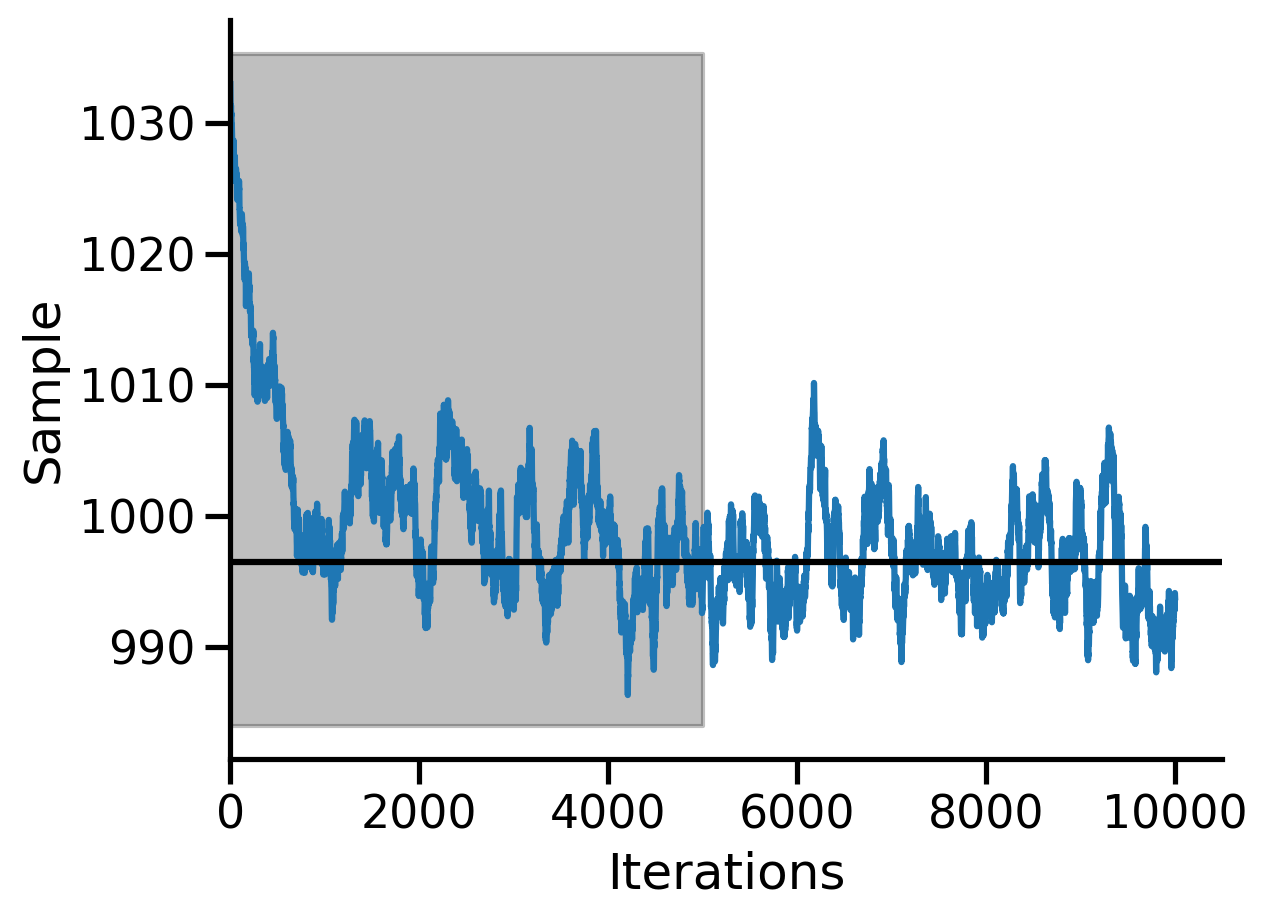

In [19]:
plt.plot(μ_samples)
plt.axhline(μ_samples[burnin:].mean(), color='k')
plt.fill_betweenx(plt.ylim(), 0, burnin, color='k', alpha=0.25)
plt.xlabel('Iterations')
plt.ylabel('Sample')
plt.xlim(0, None)
sns.despine()

This looks good - the samples fluctuate around their mean (black line), and we can see that the chain seemed to have settled after the burnin time (shaded area).

Lets get rid of the burnin samples.

In [20]:
μ_samples = μ_samples[burnin:]

How did the MCMC proceed through the posterior space?

You can see that most of the time the chain was at high log-posterior, but occassionaly it traveled through lower log-posterior reigons of the $\mu$ range.

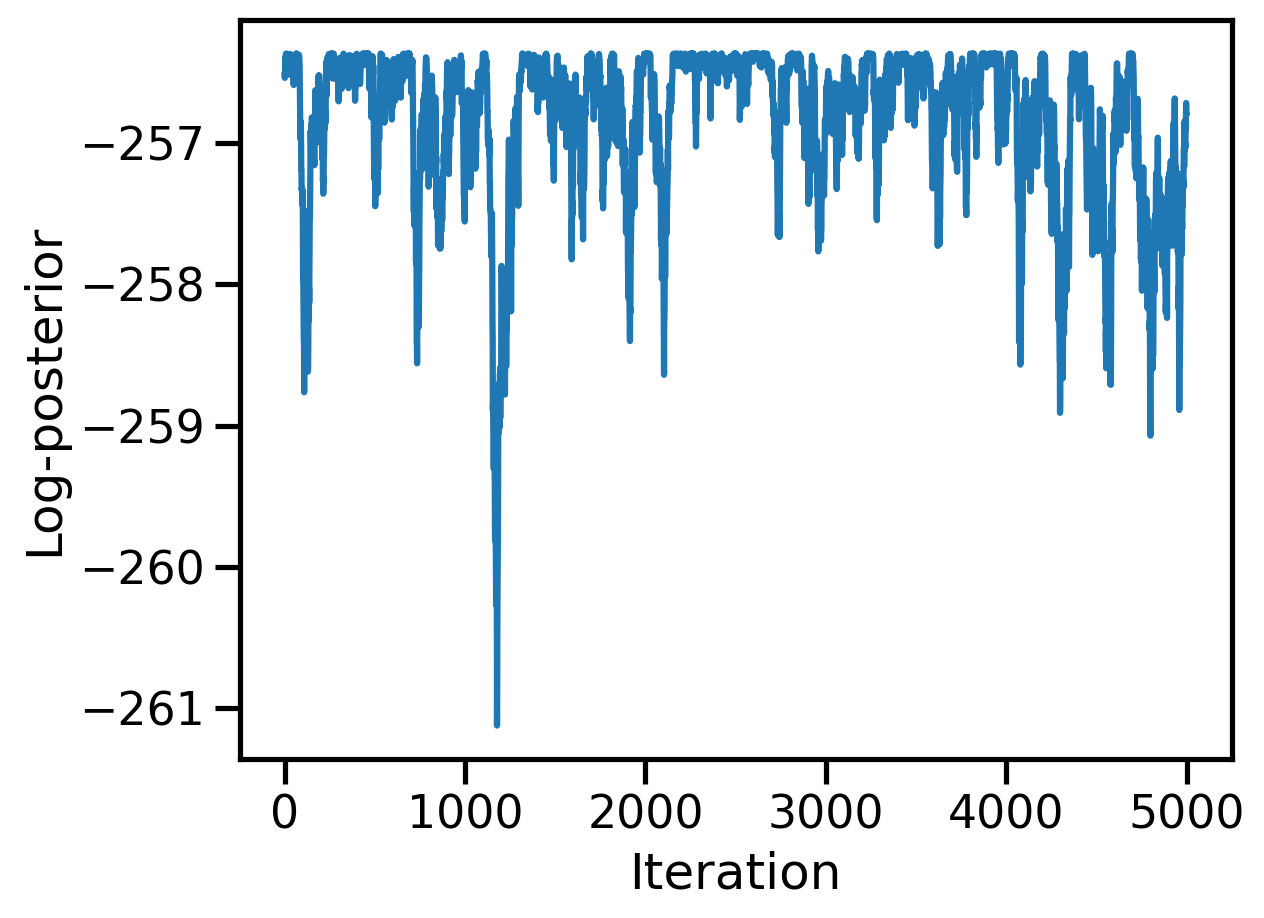

In [21]:
plt.plot(logposteriors[burnin:])
plt.xlabel('Iteration')
plt.ylabel('Log-posterior');

Let's take the mean of the post-burnin samples as our MAP (maximum a posteriori) estimate.

That makes sense if the posterior is symmetric and unimodal - we can check that.

μ = 1000 
μ_hat = 996.48 +/- 3.80


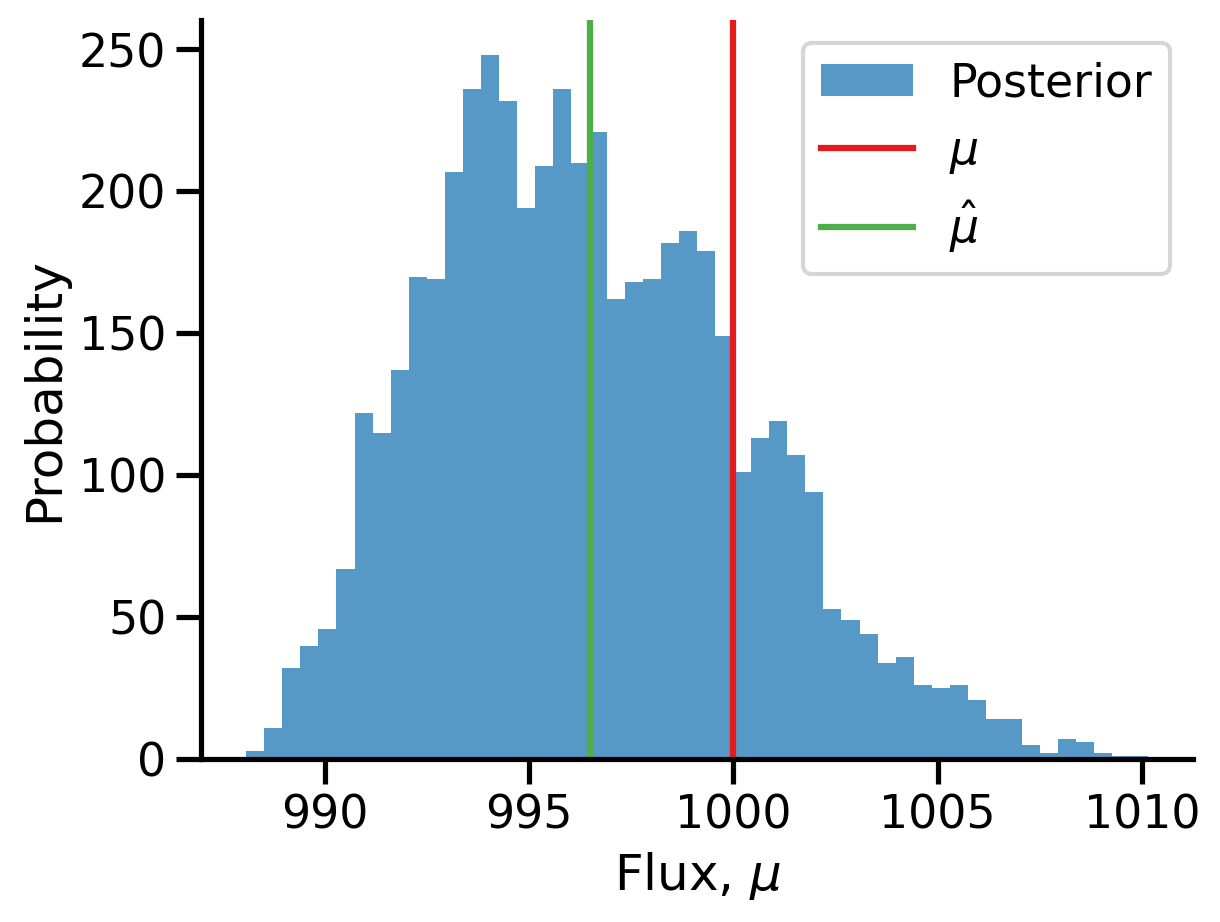

In [22]:
μ_hat = μ_samples.mean()
σ_hat = μ_samples.std()

print("μ = {} \nμ_hat = {:.2f} +/- {:.2f}".format(
    μ, μ_hat, σ_hat))

plt.hist(μ_samples, bins=50, alpha=0.75, label='Posterior')
plt.axvline(μ, color=red, label=r'$\mu$')
plt.axvline(μ_hat, color=green, label=r'$\hat{\mu}$')

plt.xlabel("Flux, $\mu$")
plt.ylabel("Probability")
plt.legend()
sns.despine()

Other interesting diagnostics we can do are to look at the differences between consecutive samples.
Their distribution should match the proposal distribution $N(0, \eta)$, ploted below as a black line.

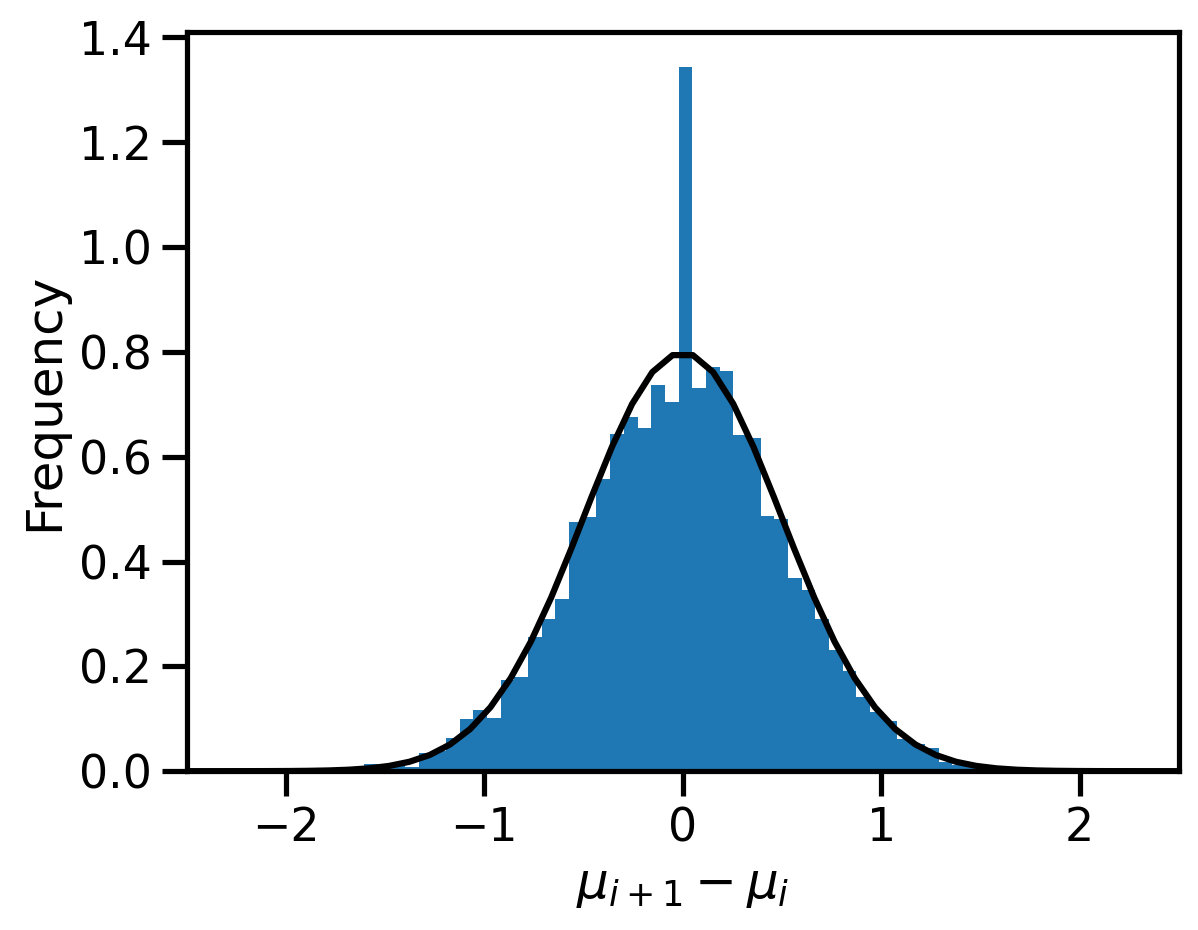

In [23]:
diff = μ_samples[1:] - μ_samples[:-1]
plt.hist(diff, bins=50, density=True)
diff_range = np.linspace(-η*5, η*5)
plt.plot(diff_range, scipy.stats.norm.pdf(diff_range, 0, η), color='k')
plt.xlim(-η*5, η*5)
plt.xlabel(r'$\mu_{i+1}-\mu_i$')
plt.ylabel('Frequency');

This is important because it means that our samples are correlated. We want to make sure that they are weakly correlated -- that the correlation is lost after a few iterations

We can check the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation), which is a measure of how much sample $i$ is correlated with sample $i+k$ (with lag $k$). We want to check that the correlation quickly goes down with $k$.

We can see that here that is the case and that the autocorrelation goes down with the lag $k$.

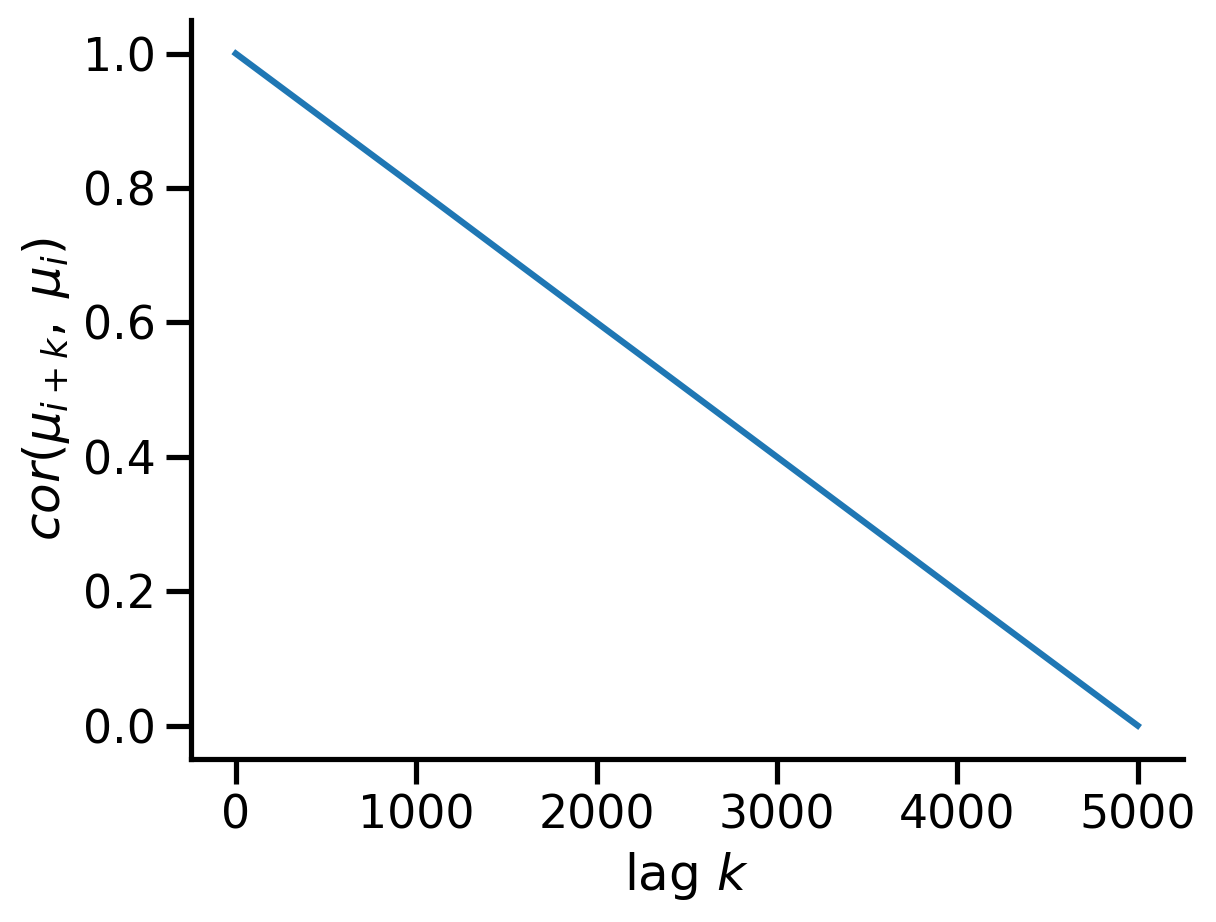

In [24]:
autocorr = np.correlate(μ_samples, μ_samples, mode='full')
autocorr /= autocorr.max()
autocorr = autocorr[autocorr.size // 2 :]

plt.plot(autocorr)
plt.xlabel('lag $k$')
plt.ylabel('$cor(\mu_{i+k}, \; \mu_i)$')
sns.despine()

## emcee: The MCMC Hammer

Now that we understand how sampling could work, we will use a more sophisticated an [affine-invariant ensemble sampler for Markov chain Monte Carlo (MCMC)](https://arxiv.org/abs/1202.3665): the **[emcee](https://emcee.readthedocs.io/)** package.

In [25]:
import emcee

If you need to install `emcee` (i.e., you are getting an `ImportError`) run the following command in a separate cell: `!python3.7 -m pip install emcee`.

To setup the sampler, we generate some random starting guesses for multiple chains of samples.
In `emcee` chains are called "walkers".

In [26]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nsteps = 10000 // nwalkers  # number of MCMC steps to take
nburn = nsteps // 2  # "burn-in" period to let chains stabilize

# we'll start at random locations between 0 and 2000
guesses = 2000 * np.random.rand(nwalkers, ndim)

We can now crate the sampler and run it. This will take a few minutes.

In [27]:
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, 
    ndim=ndim,
    log_prob_fn=log_posterior,
    args=[X]
)
sampler.run_mcmc(
    initial_state=guesses,
    nsteps=nsteps
)

# sampler.chain.shape = (nwalkers, nsteps, ndim)
# discard burn-in points and flatten with ravel()
sample = sampler.chain[:, nburn:, :].ravel()

If this all worked correctly, the array `sample` should contain a series of 5,000 points drawn from the posterior. Let's plot them and check.

In [28]:
μ_hat = sample.mean()
std_hat = sample.std()

print("μ = {} \nμ_hat = {} +/- {}".format(
    μ, μ_hat, std_hat))

μ = 1000 
μ_hat = 997.7263943540055 +/- 4.0936400245224


Before examining the posterior distribution, lets look at the trace plot, which shows:
1. the posterior distributions for each chain
1. the samples for each chain -- the $\mu$ sample values across time.

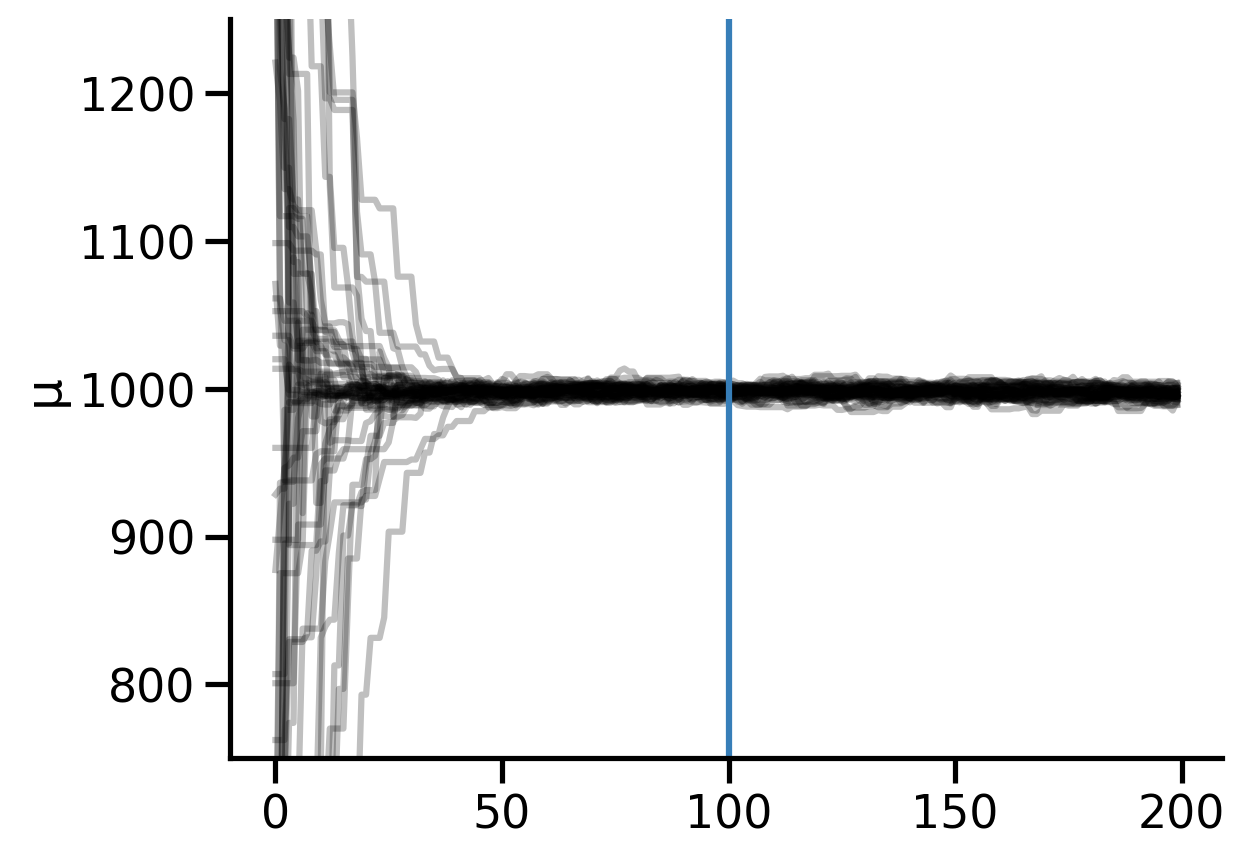

In [29]:
plt.plot(sampler.chain[:,:,0].T, color='k', alpha=0.25);
plt.axvline(nburn, color=blue)
plt.ylabel('μ')
plt.ylim(750, 1250)

sns.despine()

You can see here why we need to remove the initial `nburn` samples (or maybe less of them). 

Now we can plot the posterior distribution, together with the estimate (green) $\pm$ standard deviation (dashed black lines), the true value (red). We can see that the true value is within the one standard deviation of the estimate, which is pretty good.

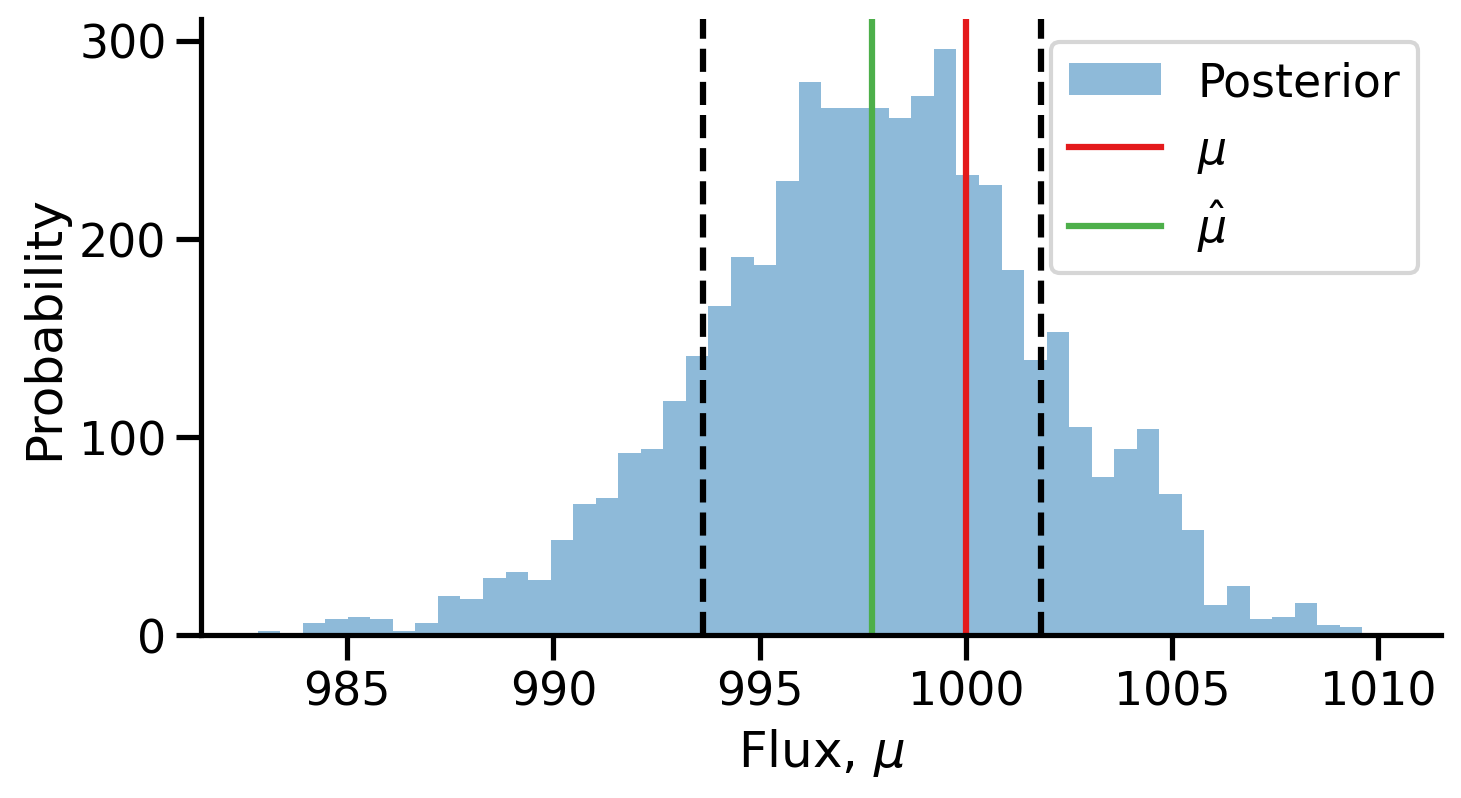

In [30]:
plt.figure(figsize=(8, 4))
plt.hist(sample, bins=50, alpha=0.5, label='Posterior')
plt.axvline(μ, color=red, label=r'$\mu$')
plt.axvline(μ_hat, color=green, label=r'$\hat{\mu}$')
plt.axvline(μ_hat+std_hat, color='k', ls='--')
plt.axvline(μ_hat-std_hat, color='k', ls='--')

plt.xlabel("Flux, $\mu$")
plt.ylabel("Probability")
plt.legend()
sns.despine()

For this simple problem, both approaches yield the same result, more or less.

# Complex model for photon count

We now assume that the light source is dynamic and stochastic (e.g. Quasar).

That is, the measurements $\{X_i\}$ are still drawn from a Poisson distribution, but the expectation ($F_i$) changes over time -- it is drawn from a normal distrubtion with expectation $\mu$ and standard deviation $\sigma$:
$$
F_i \sim N(\mu, \sigma) \\
X_i \sim Poi(F_i)
$$

We note the model parameters as $\theta = (\mu, \sigma)$.

Let's generate data according to this model.

In [31]:
# for reproducibility
np.random.seed(42)
# we'll use more samples for the complex model
n = 100  
# parameters stochastic flux model
θ = (μ, σ) = 1000, 15
# (unknown) true flux
F = np.random.normal(μ, σ, size=n)
# observed flux: true flux plus Poisson errors
X = np.random.poisson(F)

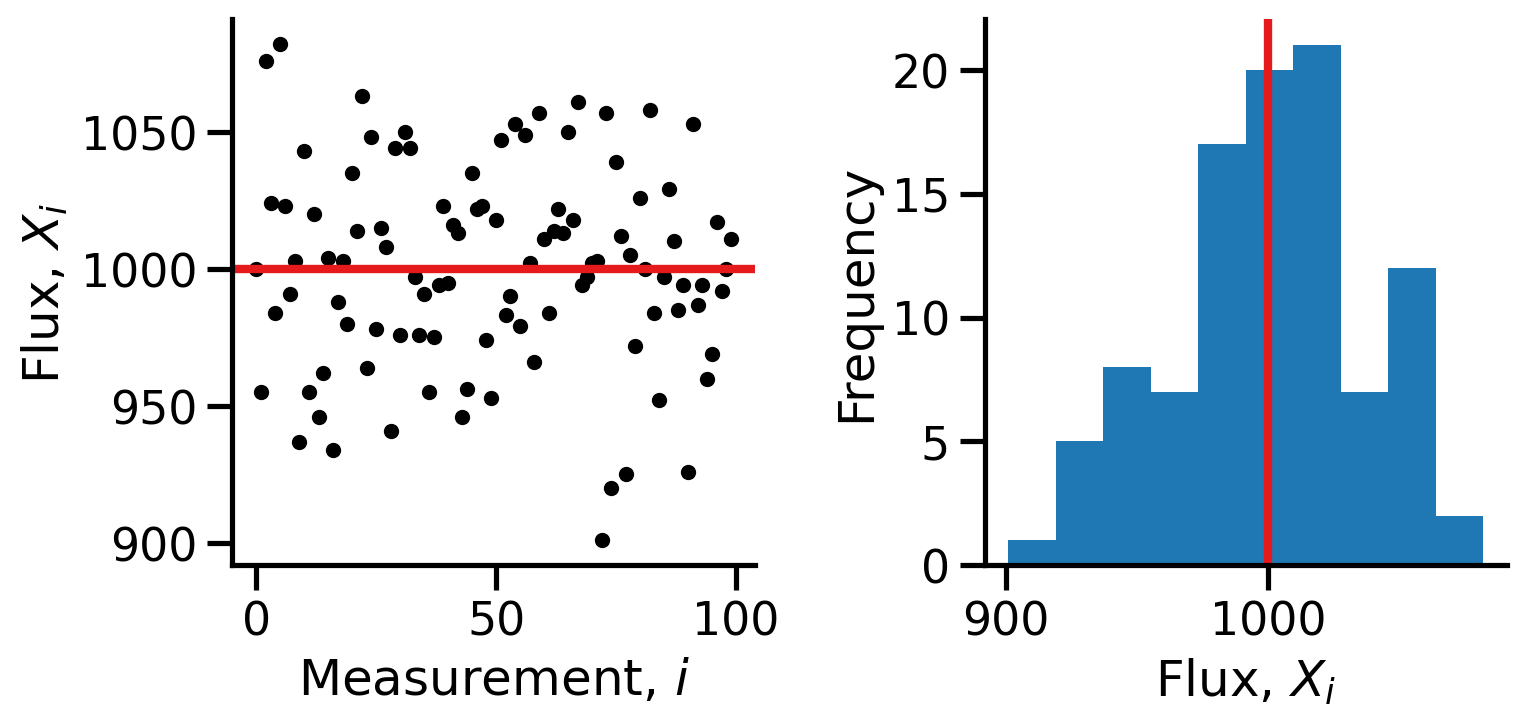

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(n), X, '.k')
ax.axhline(μ, linewidth=3, color=red)
ax.set_xlabel("Measurement, $i$")
ax.set_ylabel("Flux, $X_i$")

ax = axes[1]
ax.hist(X, bins=10)
ax.axvline(μ, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Frequency")
ax.set_xlabel("Flux, $X_i$")

fig.tight_layout()
sns.despine()

To find the likelihood we can the normal approximation of the Poisson distribution, which works well for high expected values, so that 
$$
F_i \sim N(\mu, \sigma^2) \\
X_i \sim Poi(F_i) \approx N(F_i, F_i)
$$

This is useful because compounding normal distributions gives a normal distribution with a sum of variances:

$$
X_i \approx N(\mu, \sigma^2 + e_i^2)
$$
where we estimate $e_i^2 \approx X_i$, just like we would estimate $\mu \approx X_i$.

The likelihood function is therefore

$$
\mathcal{L}(\mu, \sigma~|~X) = 
\prod_{i=1}^n \frac{1}{\sqrt{2\pi(\sigma^2 + X_i)}}\exp\Big[\frac{-(X_i - \mu)^2}{2(\sigma^2 + X_i)}\Big]
$$

## Exercise 2: log-likelihood

**Implement `log_likelihood(θ, X)`**, where $\theta = (\mu, \sigma)$ and `X` is the data.

You can check the [solution](../solutions/bayesian.ipynb) afterwards.

In [34]:
def log_likelihood(θ, X):
    ## your code here

log_likelihood(θ, X)

-503.223428772118

We used SciPy's optimization routines to find the maximum likelihood (and then bootstrap to find confidence intervals).

In [35]:
def neg_log_likelihood(θ, X):
    return -log_likelihood(θ, X)

θ_guess = (900, 5)
θ_hat = scipy.optimize.fmin(
    func=neg_log_likelihood, 
    x0=θ_guess, 
    args=(X,)
)
μ_hat, σ_hat = θ_hat
print("μ = {} \tμ_hat = {:.2f}\nσ = {}\t\tσ_hat = {:.2f}".format(
    μ, μ_hat, σ, σ_hat))

Optimization terminated successfully.
         Current function value: 502.839505
         Iterations: 58
         Function evaluations: 114
μ = 1000 	μ_hat = 999.23
σ = 15		σ_hat = 19.35


## Bayesian inference

This is very similar to the previous case, with minor modifications to introduce the second parameter $\sigma$.

We start with uninformative priors.

In [36]:
def log_prior(θ):
    μ, σ = θ
    # both parameters need to be positive
    if μ > 0 and σ > 0:
        return 0
    else:
        return -np.inf

def log_posterior(θ, X):
    pri = log_prior(θ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood(θ, X)

In [37]:
ndim = 2
nwalkers = 50
nsteps  = 10000 // nwalkers
nburn = nsteps // 2

guesses = np.random.rand(nwalkers, ndim)
guesses[:, 0] *= 2000  # start mu between 0 and 2000
guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[X])
sampler.run_mcmc(guesses, nsteps)

# sampler.chain.shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

In [38]:
μ_sample, σ_sample = sample[:, 0], sample[:, 1]
μ_hat, σ_hat = μ_sample.mean(), (σ_sample).mean()

print("μ = {} \tμ_hat = {:.2f}\nσ = {}\t\tσ_hat = {:.2f}".format(
    μ, μ_hat, σ, σ_hat))

μ = 1000 	μ_hat = 998.60
σ = 15		σ_hat = 18.54


These estimates are very similar to those of the frequentist approach.

Lets check the trace plot first.

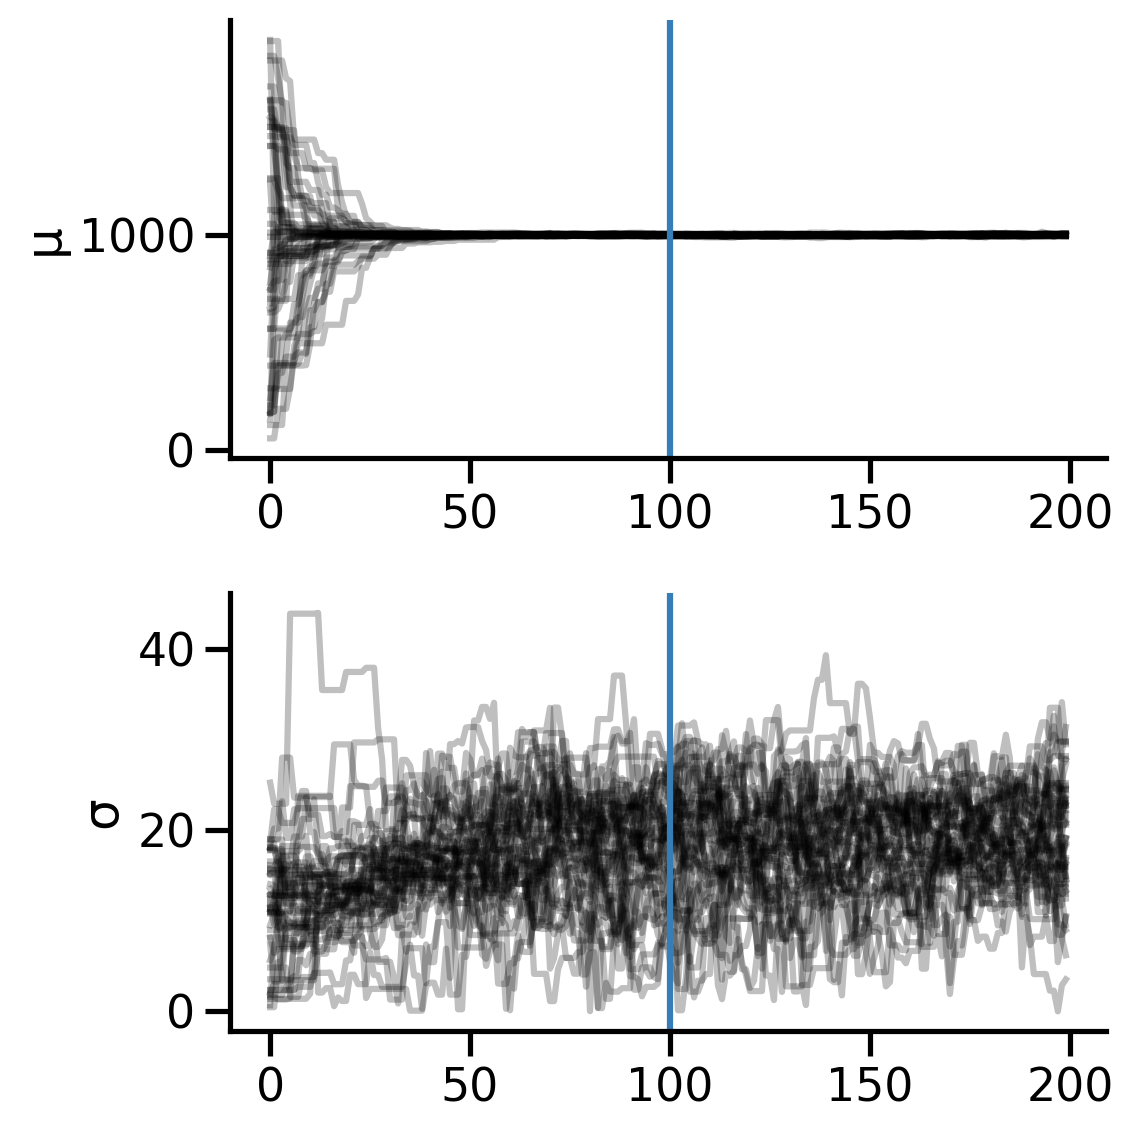

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

for i, varname in enumerate(['μ', 'σ']):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i].T, color='k', alpha=0.25);
    ax.axvline(nburn, color=blue)
    ax.set_ylabel(varname)

fig.tight_layout()
sns.despine()

Looks about right.

We now plot the poterior distribution: the joint in the center, and the marginals on the right and top.
Here, we use a kernel density estimate plot, which tries to estimate the posterior densities using Gaussian kernels (we'll discuss how this is done later in the course).

We also plot a few chains on top of the joint density plot so that we can illustrate how the MCMC algorithm works.

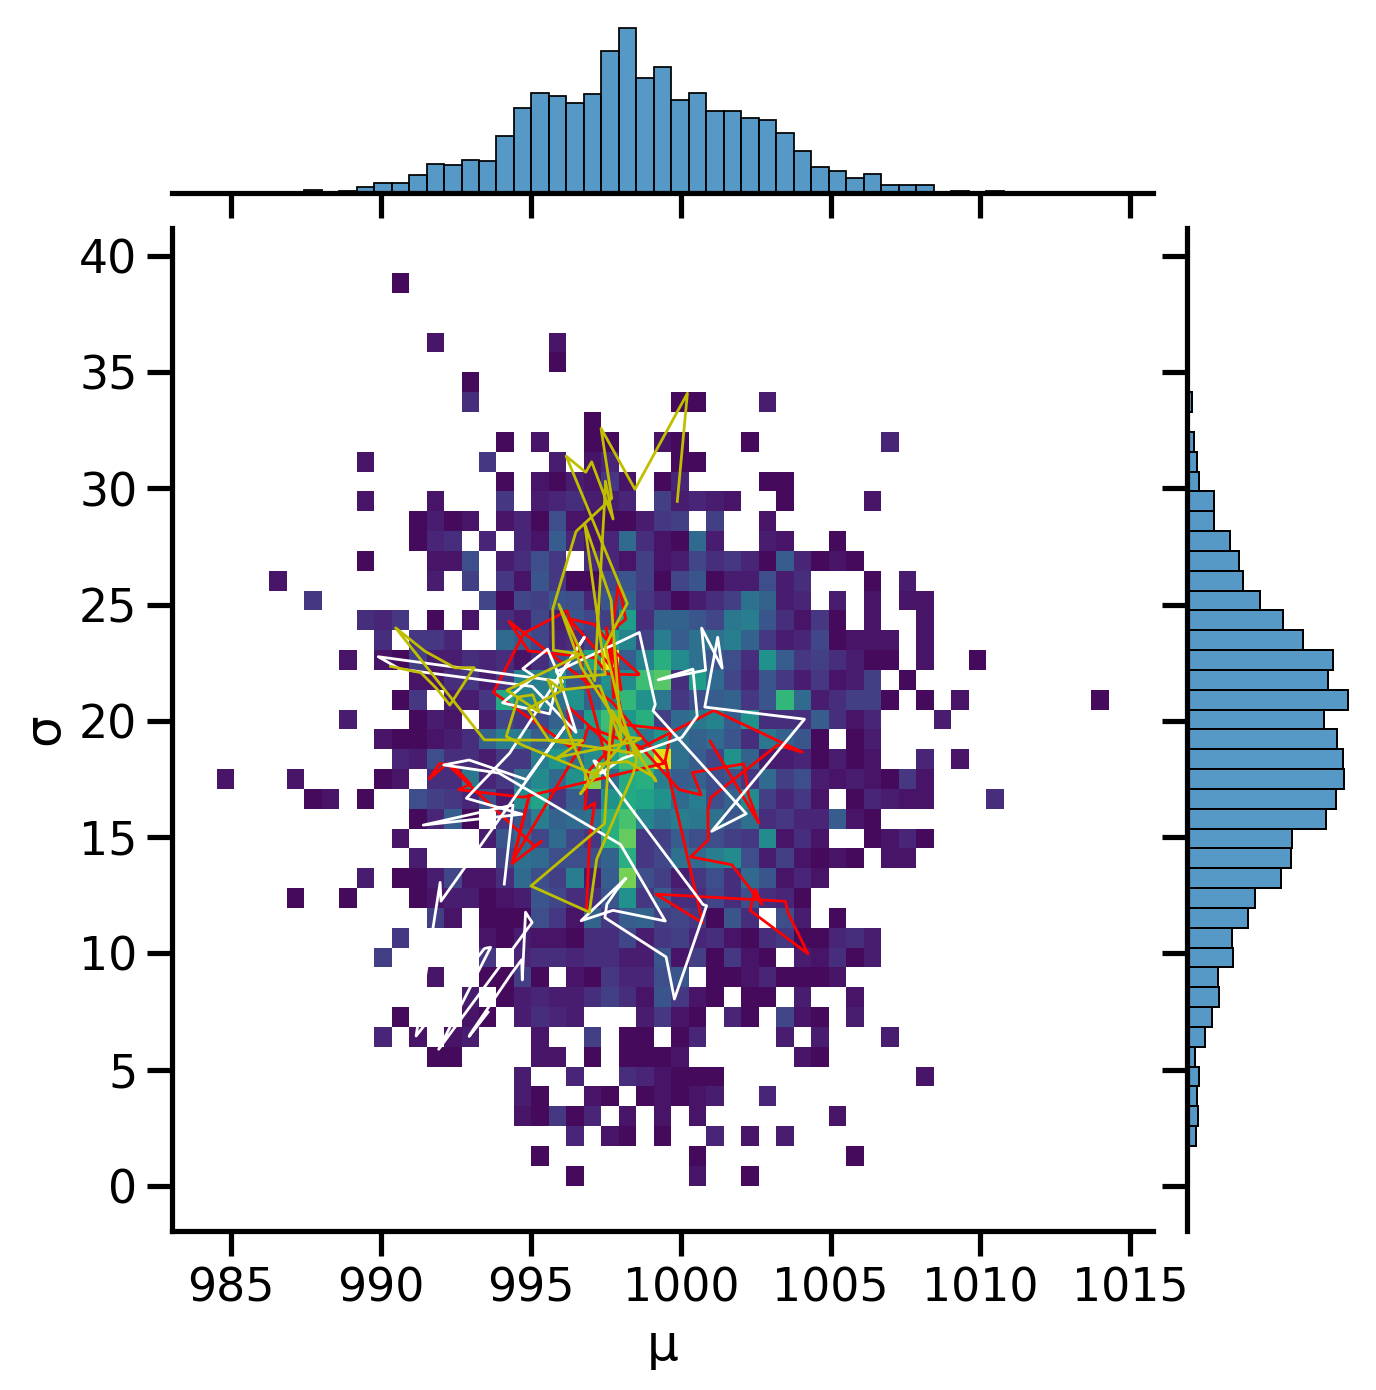

In [40]:
g = sns.jointplot(
    x=sampler.chain[:, nburn :, 0].ravel(), 
    y=sampler.chain[:, nburn:, 1].ravel(), 
    kind='hist', cmap='viridis', height=7)
g.set_axis_labels('μ', 'σ')

for i, c in enumerate('rwy'):
    g.ax_joint.plot(sampler.chain[i, nburn:, 0], sampler.chain[i, nburn:, 1], lw=1, color=c)

Note how the distributions all look prety much Gaussian, which is good.

We can also plot the posterior distribution using the [corner](http://corner.readthedocs.io) package.

Here, the contours on the joint plot show one and two standard deviations (of a gaussian) to demonstrate confidence regions. This demonstrates that the truth is just on the edge of the confidence region.

In [41]:
from corner import corner 

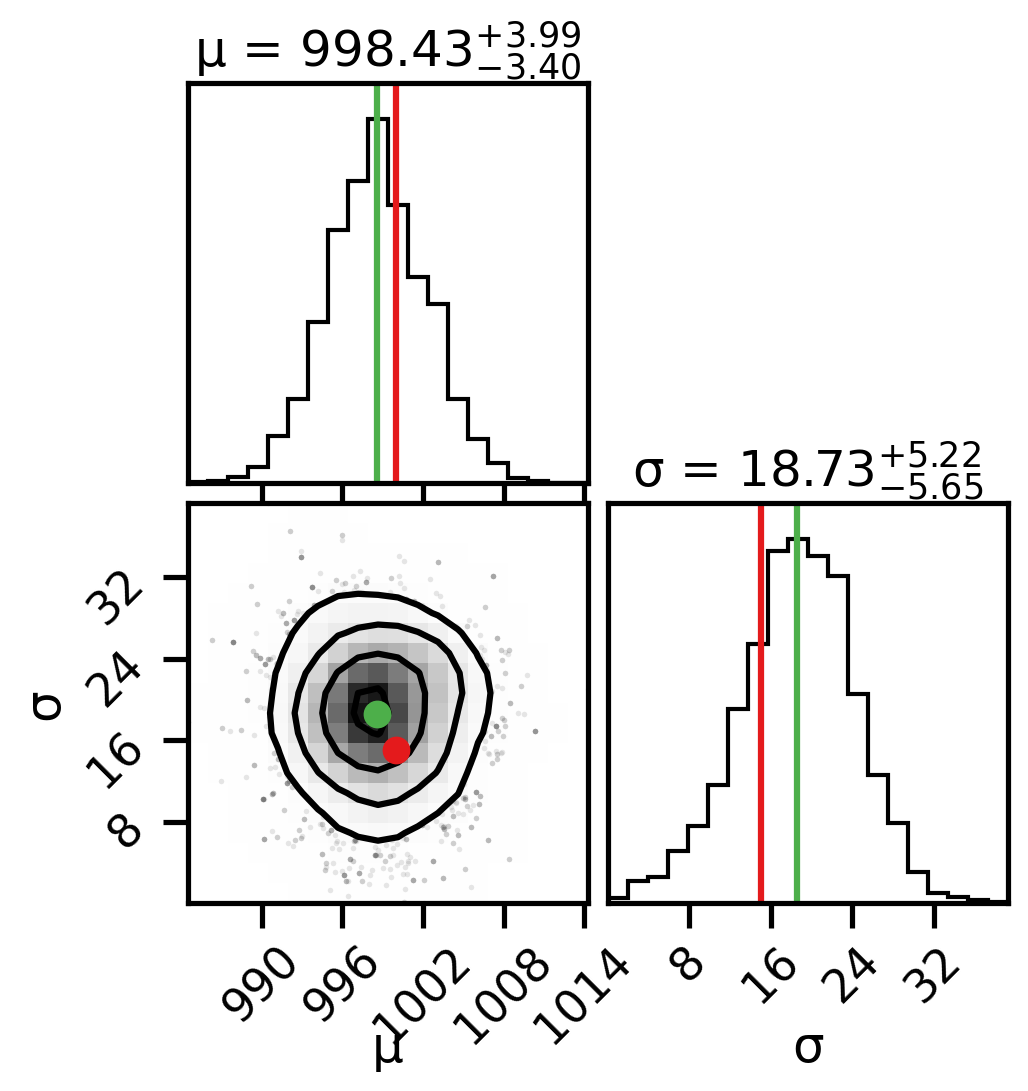

In [42]:
cor = corner(sample, 
    smooth=True,
    labels=['μ', 'σ'],
    show_titles=True,
)
cor.axes[0].axvline(μ, color=red)
cor.axes[3].axvline(σ, color=red)
cor.axes[2].plot(μ, σ, 'o', color=red);
cor.axes[0].axvline(μ_hat, color=green)
cor.axes[3].axvline(σ_hat, color=green)
cor.axes[2].plot(μ_hat, σ_hat, 'o', color=green);

This is very similar to what we found using bootstrap and maximum likelihood: this shows that in many cases the frequentist and Bayesian approaches can lead to similar results using different approachs.

# References

- Jake VanDerPlas's series of [blog posts on Bayesian inference](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
- Cam Davidson-Pilon's book [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
- [emcee](https://emcee.readthedocs.io/): the MCMC Hammer
- [corner](http://corner.readthedocs.io/) is a package for plotting joint and marginal density plots
- [ArviZ](https://arviz-devs.github.io/arviz) is a package for plotting MCMC results

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Data Science with Python_](https://python.yoavram.com/Deep4Devs) workshops.

The notebook was written using [Python](http://python.org/) 3.6.3, [IPython](http://ipython.org/) 6.2.1, [Jupyter](http://jupyter.org) 5.1.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)